# Kaggle Competition: Tabular Playground Series - Aug 2022 (Post competition notebook)
## This notebook achieves a leadearbord Private Score of 0.59051 (position 53 of 1888 participants, which corresponds to top 2.81%)
### Supervised machine learning binary classification problem.
#### The (fictional) data represents the results of a large product testing study of a (fictional) company. The task is to use the data resulting from the study to predict individual product failures.
#### For more information see: https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/overview

#### Notebook author: Arnau Juanmarti
#### Last edited: March 9, 2023

## Table of Contents
* [Settings](#settings)
* [Exploratory Data Analysis](#eda)
    * [Distribution of target](#target)
    * [Distribution of continuous features and relationship with target](#continuous)
    * [Distribution of categorical features and relationship with target](#categorical)
* [Preprocessing](#preprocessing)
    * [Missing data](#missings)
        * [Adding indicators for missing values](#indicators)
        * [Imputing missing data](#imputing)
    * [Feature Engineering](#featureengineering)
        * [Cliping](#cliping)
        * [Normalizing the loading feature](#normalizing)
        * [Summary features](#summaries)
    * [Encoding](#encoding)
        * [Labeling](#labeling)
        * [One-Hot Encoding](#ohe)
    * [Scaling](#scaling)
* [Modeling](#modeling)
    * [Train and test data for modeling](#traintest)
    * [Hyperparameter tuning](#hyper)
    * [Cross-validation strategy](#cvstrategy)
    * [Feature importances](#featureimportances)
    * [Automatic feature selection with Recursive Feature Elimination (RFE)](#featureselection)
    * [Ensembling models with different sets of features to reduce overfitting](#ensembling)
* [Submission](#submission)

# SETTINGS <a class='anchor' id='settings'></a>

#### Specify notebook settings

In [11]:
## This is to make output cells scrollable horizontally when output does not fit the screen.
#from IPython.display import display, HTML
#display(HTML("<style>pre { white-space: pre !important; }</style>"))

## This is to ensure imported custom modules get loaded automatically when the module is edited.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Specify project directory

In [12]:
import os
os.chdir('C:/Users/Arnau Juanmarti/machinelearning_projects/Kaggle Competitions/TPS Aug 2022 Predicting individual product failures')

#### Import packages

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import own_functions as own ## Module with own custom functions
from own_functions import df_summary
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from dataclasses import dataclass
from sklearn.model_selection import StratifiedKFold
import optuna
import pickle
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Iterable
from sklearn.feature_selection import RFECV

#### Specify pandas display options

In [14]:
desired_width=320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns',50)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)

#### Import data

In [15]:
train = pd.read_csv('Original data/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('Original data/tabular-playground-series-aug-2022/test.csv')
sample_submission = pd.read_csv('Original data/tabular-playground-series-aug-2022/sample_submission.csv')

#### Tagging variables

In [16]:
id = 'id'
target = 'failure'
cont_cols = [f'measurement_{i}' for i in range(3, 18, 1)] + ['loading']
cat_cols = [f'measurement_{i}' for i in range(0, 3, 1)] + [f'attribute_{i}' for i in range(0, 4, 1)] + ['product_code']

# EXPLORATORY DATA ANALYSIS <a class='anchor' id='eda'></a>

In [17]:
df_summary(train)

Number of rows: 26570


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,26570,0,0.000000,"[0, 1, 2, 3, 4]"
product_code,object,5,0,0.000000,"[A, A, A, A, A]"
loading,float64,11950,250,0.940911,"[80.1, 84.89, 82.43, 101.07, 188.06]"
attribute_0,object,2,0,0.000000,"[material_7, material_7, material_7, material_7, material_7]"
attribute_1,object,3,0,0.000000,"[material_8, material_8, material_8, material_8, material_8]"
attribute_2,int64,4,0,0.000000,"[9, 9, 9, 9, 9]"
attribute_3,int64,4,0,0.000000,"[5, 5, 5, 5, 5]"
measurement_0,int64,29,0,0.000000,"[7, 14, 12, 13, 9]"
measurement_1,int64,30,0,0.000000,"[8, 3, 1, 2, 2]"
measurement_2,int64,25,0,0.000000,"[4, 3, 5, 6, 8]"


In [18]:
df_summary(test)

Number of rows: 20775


,Type,N Unique Values,N Missings,% Missings,Values
id,int64,20775,0,0.000000,"[26570, 26571, 26572, 26573, 26574]"
product_code,object,4,0,0.000000,"[F, F, F, F, F]"
loading,float64,10741,223,1.073406,"[119.57, 113.51, 112.16, 112.72, 208.0]"
attribute_0,object,2,0,0.000000,"[material_5, material_5, material_5, material_5, material_5]"
attribute_1,object,3,0,0.000000,"[material_6, material_6, material_6, material_6, material_6]"
attribute_2,int64,3,0,0.000000,"[6, 6, 6, 6, 6]"
attribute_3,int64,4,0,0.000000,"[4, 4, 4, 4, 4]"
measurement_0,int64,30,0,0.000000,"[6, 11, 8, 8, 14]"
measurement_1,int64,33,0,0.000000,"[9, 8, 12, 11, 16]"
measurement_2,int64,28,0,0.000000,"[6, 0, 4, 10, 8]"


## Distribution of target <a class='anchor' id='target'></a>

Text(0.5, 0.98, 'Distribution of failure')

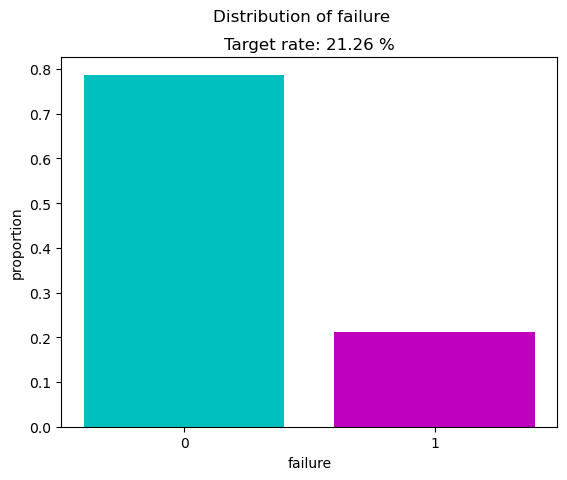

In [19]:
fig, ax = plt.subplots()
ax.bar(train[target].value_counts().index, train[target].value_counts().values / len(train), color=['c', 'm'])
ax.set_xticks(range(len(train[target].value_counts().index)), train[target].value_counts().index)
ax.set(xlabel=target, ylabel='proportion', title=f'Target rate: {round(np.mean(train[target]) * 100, 2)} %')
fig.suptitle(f'Distribution of {target}')

## Distribution of continuous features and relationship with target <a class='anchor' id='continuous'></a>
The following figure shows the distribution of each of the continuous features for both train and test sets and a scatterplot of the feature with the target rate.

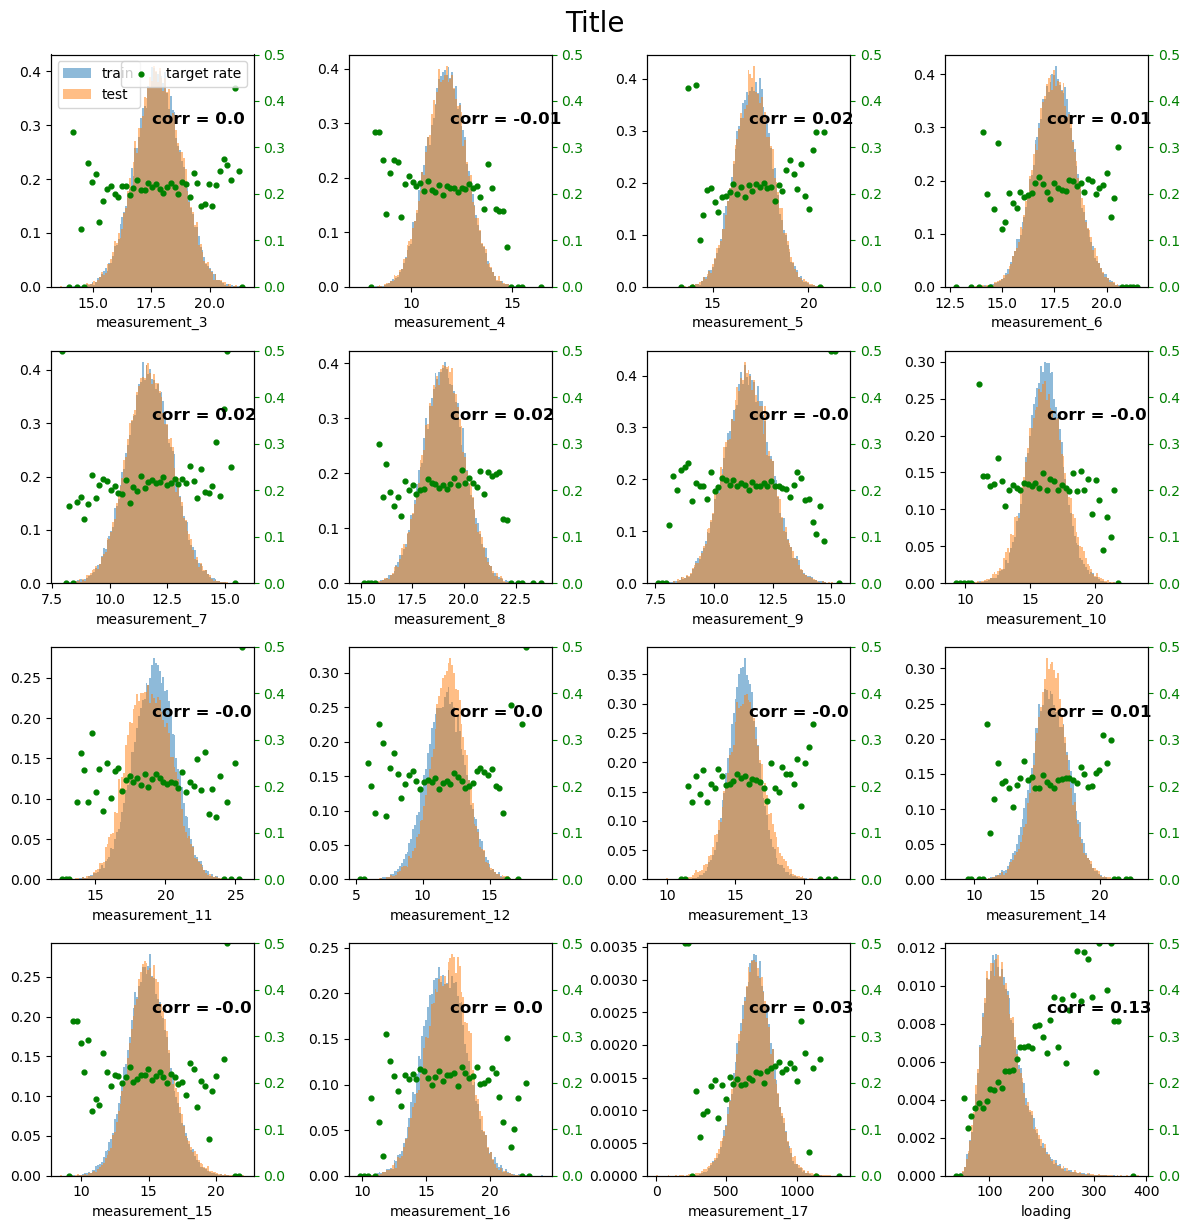

In [20]:
own.plot_cont_target_all(train, test, cont_cols, rows=4, cols=4, target=target)

## Distribution of categorical features and relationship with target <a class='anchor' id='categorical'></a>
The following figure shows the distribution of each of the categorical features for both train and test sets and a scatterplot of the feature with the target rate.

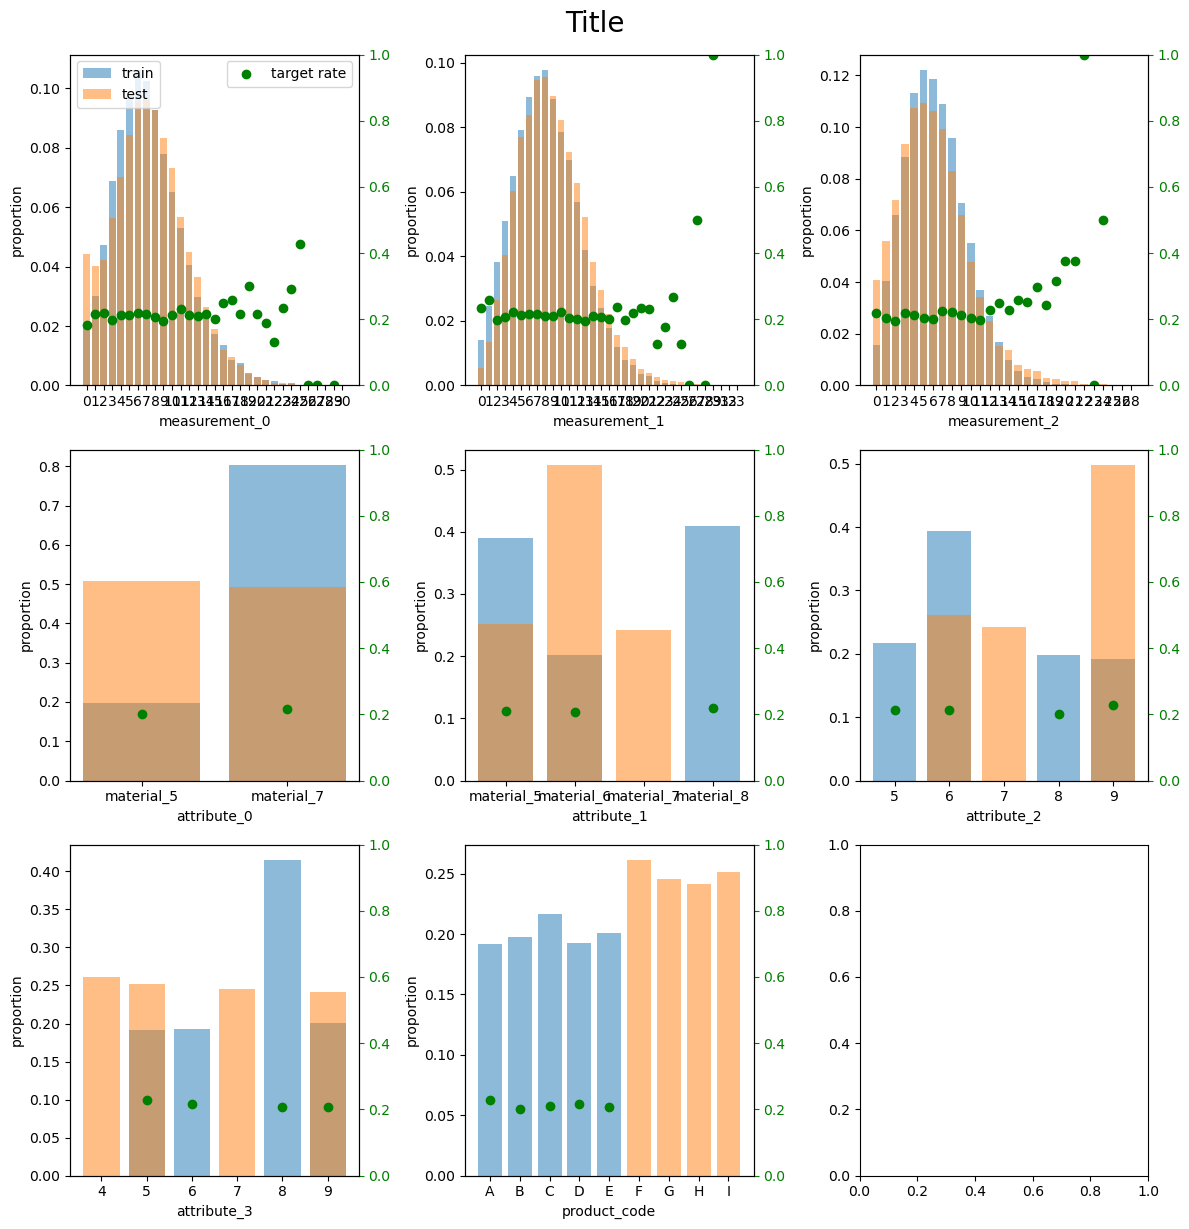

In [21]:
own.plot_cat_target_all(train, test, cat_cols, target, 3, 3, figsize=(12, 12))

# PREPROCESSING <a class='anchor' id='preprocessing'></a>

## Missing data <a class='anchor' id='missings'></a>

In [22]:
own.table_missings(train, test)

,Type,N Unique Values,% missings train,Type,N Unique Values,% missings test,First 5 values (in train)
id,int64,26570,0.00,int64,20775.0,0.00,"[0, 1, 2, 3, 4]"
product_code,object,5,0.00,object,4.0,0.00,"[A, A, A, A, A]"
loading,float64,11950,0.94,float64,10741.0,1.07,"[80.1, 84.89, 82.43, 101.07, 188.06]"
attribute_0,object,2,0.00,object,2.0,0.00,"[material_7, material_7, material_7, material_7, material_7]"
attribute_1,object,3,0.00,object,3.0,0.00,"[material_8, material_8, material_8, material_8, material_8]"
attribute_2,int64,4,0.00,int64,3.0,0.00,"[9, 9, 9, 9, 9]"
attribute_3,int64,4,0.00,int64,4.0,0.00,"[5, 5, 5, 5, 5]"
measurement_0,int64,29,0.00,int64,30.0,0.00,"[7, 14, 12, 13, 9]"
measurement_1,int64,30,0.00,int64,33.0,0.00,"[8, 3, 1, 2, 2]"
measurement_2,int64,25,0.00,int64,28.0,0.00,"[4, 3, 5, 6, 8]"


### Adding indicators for missing values <a class='anchor' id='indicators'></a>
It may be the case that a missing value for one or more of the measurements is an early indicator that the product fails. As pointed out in the discussion forums, missing values for measurements 3 and 5 are correlated with product failure. Therefore we can try to include indicators for missing values of these two measurements in the model.

In [23]:
train['m_3_missing'] = np.where(train['measurement_3'].isna(), 1, 0)
train['m_5_missing'] = np.where(train['measurement_5'].isna(), 1, 0)

test['m_3_missing'] = np.where(test['measurement_3'].isna(), 1, 0)
test['m_5_missing'] = np.where(test['measurement_5'].isna(), 1, 0)

### Imputing missing data <a class='anchor' id='imputing'></a>

#### Simple imputation techniques (not used)

Let's start with simple imputation techniques, filling missing values with the mean or median or mode depending on the distribution of the features.

In [24]:
'''
# Lists of features
mean_features = [f'measurement_{i}' for i in range(3, 18, 1)]
median_features = ['loading']

# Define imputers
imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')

# Impute
train[mean_features] = imputer_mean.fit_transform(train[mean_features])
test[mean_features] = imputer_mean.transform(test[mean_features])

train[median_features] = imputer_median.fit_transform(train[median_features])
test[median_features] = imputer_median.transform(test[median_features])

own.table_missings(train, test)
'''

"\n# Lists of features\nmean_features = [f'measurement_{i}' for i in range(3, 18, 1)]\nmedian_features = ['loading']\n\n# Define imputers\nimputer_mean = SimpleImputer(strategy='mean')\nimputer_median = SimpleImputer(strategy='median')\n\n# Impute\ntrain[mean_features] = imputer_mean.fit_transform(train[mean_features])\ntest[mean_features] = imputer_mean.transform(test[mean_features])\n\ntrain[median_features] = imputer_median.fit_transform(train[median_features])\ntest[median_features] = imputer_median.transform(test[median_features])\n\nown.table_missings(train, test)\n"

#### Imputing with KNNImputer
Imputing missing values with KNNImputer gives better performance. Using more advanced imputation techniques would probably be better. However, I have tried several other methods and they do not increase performance.

In [25]:
imputer_features = ['loading'] + [f'measurement_{i}' for i in range(3, 18, 1)]
imputer = KNNImputer(n_neighbors=3)
train[imputer_features] = imputer.fit_transform(train[imputer_features])
test[imputer_features] = imputer.transform(test[imputer_features])
own.table_missings(train, test)

,Type,N Unique Values,% missings train,Type,N Unique Values,% missings test,First 5 values (in train)
id,int64,26570,0.0,int64,20775.0,0.0,"[0, 1, 2, 3, 4]"
product_code,object,5,0.0,object,4.0,0.0,"[A, A, A, A, A]"
loading,float64,12156,0.0,float64,10915.0,0.0,"[80.1, 84.89, 82.43, 101.07, 188.06]"
attribute_0,object,2,0.0,object,2.0,0.0,"[material_7, material_7, material_7, material_7, material_7]"
attribute_1,object,3,0.0,object,3.0,0.0,"[material_8, material_8, material_8, material_8, material_8]"
attribute_2,int64,4,0.0,int64,3.0,0.0,"[9, 9, 9, 9, 9]"
attribute_3,int64,4,0.0,int64,4.0,0.0,"[5, 5, 5, 5, 5]"
measurement_0,int64,29,0.0,int64,30.0,0.0,"[7, 14, 12, 13, 9]"
measurement_1,int64,30,0.0,int64,33.0,0.0,"[8, 3, 1, 2, 2]"
measurement_2,int64,25,0.0,int64,28.0,0.0,"[4, 3, 5, 6, 8]"


## Feature Engineering <a class='anchor' id='featureengineering'></a>

### Cliping <a class='anchor' id='cliping'></a>
As we can see in the plots above, measurement 2 is correlated with the target only for values above 10. Let's trim the values below 11 at 11.

In [26]:
train['measurement_2'] = train['measurement_2'].clip(11, None)
test['measurement_2'] = test['measurement_2'].clip(11, None)

### Normalizing the loading feature (does not improve score) <a class='anchor' id='normalizing'></a>

In [27]:
#train['loading'] = np.log1p(train['loading'])
#test['loading'] = np.log1p(test['loading'])

### Summary features <a class='anchor' id='summaries'></a>
The float measurements (measurements from 3 to 17) are possibly capturing physical characteristics of the product that are related to each other. Let's try to add summary statistics of the measurements as new features.

The same argument applies to the integer measurements (measurements from 0 to 2). Let's add summary statistics of them.

In [28]:
measurement_float_cols = [f'measurement_{i}' for i in range(3, 18, 1)]

train['meas_float_mean'] = train[measurement_float_cols].mean(axis=1)
train['meas_float_median'] = train[measurement_float_cols].median(axis=1)
train['meas_float_std'] = train[measurement_float_cols].std(axis=1)
train['meas_float_min'] = train[measurement_float_cols].min(axis=1)
train['meas_float_max'] = train[measurement_float_cols].max(axis=1)

test['meas_float_mean'] = test[measurement_float_cols].mean(axis=1)
test['meas_float_median'] = test[measurement_float_cols].median(axis=1)
test['meas_float_std'] = test[measurement_float_cols].std(axis=1)
test['meas_float_min'] = test[measurement_float_cols].min(axis=1)
test['meas_float_max'] = test[measurement_float_cols].max(axis=1)

measurement_int_cols = ['measurement_0', 'measurement_1', 'measurement_2']

train['meas_int_mean'] = train[measurement_int_cols].mean(axis=1)
train['meas_int_median'] = train[measurement_int_cols].median(axis=1)
train['meas_int_std'] = train[measurement_int_cols].std(axis=1)
train['meas_int_min'] = train[measurement_int_cols].min(axis=1)
train['meas_int_max'] = train[measurement_int_cols].max(axis=1)

test['meas_int_mean'] = test[measurement_int_cols].mean(axis=1)
test['meas_int_median'] = test[measurement_int_cols].median(axis=1)
test['meas_int_std'] = test[measurement_int_cols].std(axis=1)
test['meas_int_min'] = test[measurement_int_cols].min(axis=1)
test['meas_int_max'] = test[measurement_int_cols].max(axis=1)

## Encoding <a class='anchor' id='encoding'></a>

### Labeling <a class='anchor' id='labeling'></a>
The only column to label is product_code. Because product_code has disjoint values in train and test, we first concatenate train and test and then label the column in the concateneted dataset. This way we do not generate the same label for different product codes.

In [29]:
# Concat train and test
train_test = pd.concat([train, test]).reset_index(drop=True)

# Label
lab_cols = ['product_code']

le = LabelEncoder()

for col in lab_cols:
    train_test[col] = le.fit_transform(train_test[col])

# Separate train and test
train = train_test[:train.shape[0]].reset_index(drop=True)
test = train_test[train.shape[0]:].reset_index(drop=True).drop(target, axis=1)

### One-Hot Encoding <a class='anchor' id='ohe'></a>
One-hot encode attribute_0 and attribute_1

In [30]:
ohe_attributes = ['attribute_0', 'attribute_1']
ohe_output = ['ohe0_7', 'ohe1_6', 'ohe1_8']
ohe = OneHotEncoder(categories=[['material_5', 'material_7'],
                                ['material_5', 'material_6', 'material_8']],
                    drop='first', sparse=False, handle_unknown='ignore')
ohe.fit(train[ohe_attributes])
for df in [train, test]:
    with warnings.catch_warnings(): # ignore "Found unknown categories"
        warnings.filterwarnings('ignore', category=UserWarning)
        df[ohe_output] = ohe.transform(df[ohe_attributes])
    df.drop(columns=ohe_attributes, inplace=True)

## Scaling <a class='anchor' id='scaling'></a>
Scale all features.

In [31]:
scale_features = [col for col in train.columns if col not in [id, target]]

sc = StandardScaler()

train[scale_features] = sc.fit_transform(train[scale_features])
test[scale_features] = sc.transform(test[scale_features])

# MODELING <a class='anchor' id='modeling'></a>
It looks like the model that best performs is a linear classifier such as Logistic Regression. I have tried other models and they do not improve performance. Probably the data contains a lot of noise and complex models do not add because they tend to overfit. Therefore, the modeling stage below consists in using a Logistic Regression algorithm, tuning its hyperparameters, selecting the most predictive features and ensembling several Logistic Regression models with different sets of features.

## Train and test data for modeling <a class='anchor' id='traintest'></a>

In [32]:
X = train.drop([id, target], axis=1)
y = train[target]
X_test = test.drop(id, axis=1)

## Cross-validation strategy <a class='anchor' id='cvstrategy'></a>
As we can see in the distribution plots above, product codes are disjoint between train and test sets. The train set has product codes A, B, C, D, E and the test set has product codes F, G, H, I. Because we are predicting on unseen product codes in the test set, we must ensure that our cross-validation strategy is designed such as the validation set contains unseen product codes. Therefore, we use GroupKFold splits with 4 product codes in the train sets and the remaining product code in the validation sets.

In [33]:
importances_list = []
val_scores = []
preds_test = np.zeros(test.shape[0])

gkf = GroupKFold(n_splits=5)
#prodsplit = ProductSplitter3v2()
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, X['product_code'])):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)
    model.fit(X_train, y_train)
    
    pred_val = model.predict_proba(X_val)[:,1]
    val_score = roc_auc_score(y_val, pred_val)
    val_scores.append(val_score)
    
    pred_test = model.predict_proba(X_test)[:,1]
    preds_test += pred_test / 5
    
    importances_list.append(model.coef_.ravel())
    
    
    print(f'FOLD {fold} AUC: {val_score}')
print(f'MEAN CV AUC: {np.mean(val_scores)}')

FOLD 0 AUC: 0.5875994156792729
FOLD 1 AUC: 0.5830262208282243
FOLD 2 AUC: 0.5907926008582758
FOLD 3 AUC: 0.5960202338129497
FOLD 4 AUC: 0.5942608172879568
MEAN CV AUC: 0.5903398576933359


## Feature importances <a class='anchor' id='featureimportances'></a>
Let's plot the feature importances to help us decide which features to include.

Text(0, 0.5, 'Feature')

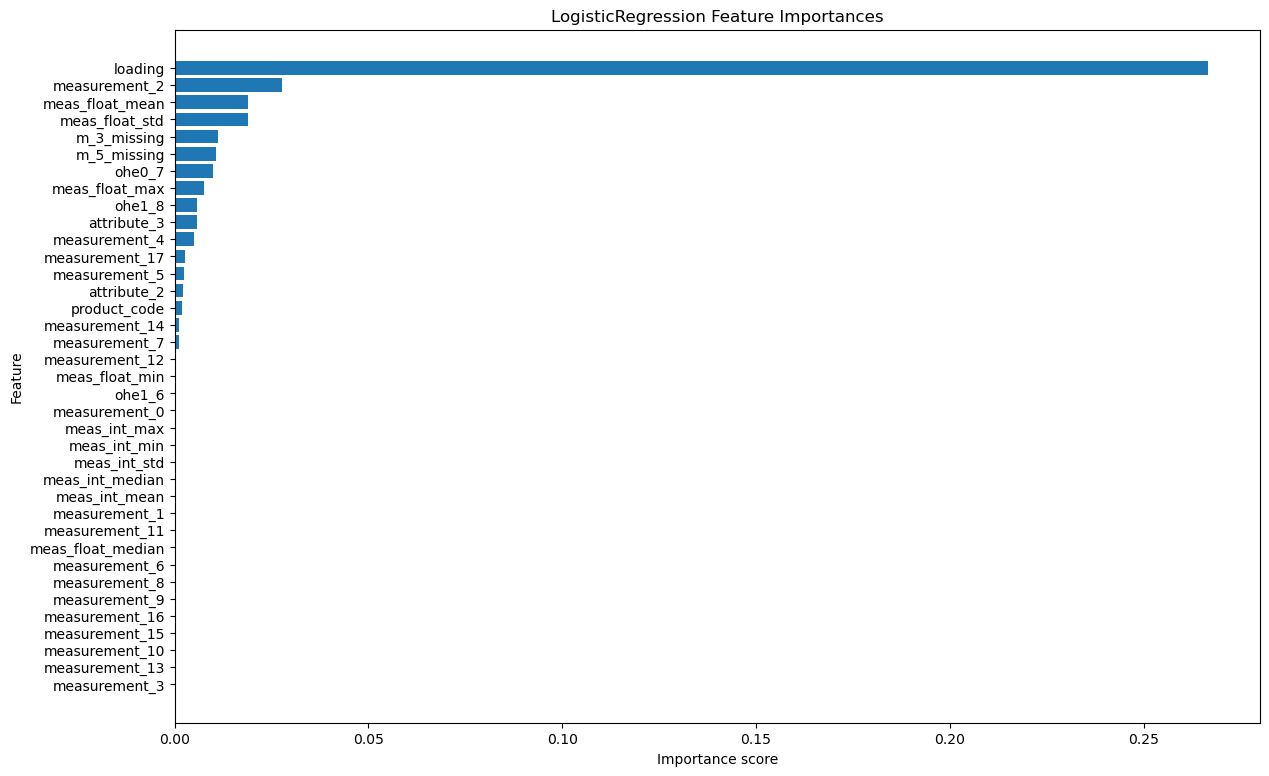

In [34]:
importance_mean = np.absolute(np.mean(np.array(importances_list), axis=0))
importances_df = pd.DataFrame({'feature': X.columns, 'importance': importance_mean}).sort_values('importance', ascending=False)
plt.figure(figsize=(14, 9))
plt.barh(importances_df['feature'], importances_df['importance'])
plt.gca().invert_yaxis()
plt.title('LogisticRegression Feature Importances')
plt.xlabel('Importance score')
plt.ylabel('Feature')

We can see that many of the features are useless for predicting the target. Because we have used l1 regularization these features are assigned a weight of 0 and are discarded internally by the Logistic Regression algorithm. This is alerady a form of feature selection, but let's see if we can improve by performing automatic feature selection with Recursive Feature Elimination (RFE).

## Automatic feature selection with Recursive Feature Elimination (RFE) <a class='anchor' id='featureselection'></a>
The following function performs RFE using the same cross-validation strategy as before. It returns a dataframe with the features ranked, a list with the selected features, a list with the not selected features and the CV score for the model with the optimal number of features. It also produces a plot showing the CV score for each combination of features.

In [35]:
def rfecv_custom(estimator, cv, scoring, X, y, name):
    rfecv = RFECV(estimator=estimator, cv=cv, scoring=scoring, verbose=0)
    rfecv.fit(X, y, X['product_code'])

    cv_results_df = pd.DataFrame(rfecv.cv_results_)
    n_features_selected = rfecv.n_features_
    features_selected_bool = rfecv.support_.tolist()
    features_selected_ranking = rfecv.ranking_.tolist()
    best_cv_score = cv_results_df['mean_test_score'].sort_values(ascending=False).reset_index(drop=True)[0]

    rfe_df = pd.DataFrame(columns=['Feature', 'Selected', 'Ranking'])
    rfe_df['Feature'] = X.columns
    rfe_df['Selected'] = features_selected_bool
    rfe_df['Ranking'] = features_selected_ranking
    selected_features = rfe_df[rfe_df['Selected'] == True]['Feature'].tolist()
    notselected_features = rfe_df[rfe_df['Selected'] == False]['Feature'].tolist()
    rfe_df.sort_values(by='Ranking', ascending=True, inplace=True)
    rfe_df.reset_index(drop=True, inplace=True)

    print(rfe_df)
    print(' ')
    print('Optimal number of features: ' + str(n_features_selected) + ' (from ' + str(X.shape[1]) + ')')
    print(' ')
    print('CV Score: ' + str(best_cv_score))
    print(' ')
    print('Features selected: ')
    print(selected_features)
    print(' ')
    print('Features not selected: ')
    print(notselected_features)

    plt.figure(figsize=(10, 6))
    plt.suptitle('Cross-validation mean score for RFE', fontsize=18)
    plt.title(
        'Best CV score: ' + str(round(best_cv_score, 4)) + '\n' + 'N features selected: ' + str(n_features_selected),
        fontsize=10)
    plt.xlabel('Number of features selected')
    plt.ylabel('CV Score')
    plt.plot(range(1, cv_results_df.shape[0] + 1), cv_results_df['mean_test_score'])
    plt.xticks(ticks=range(1, cv_results_df.shape[0] + 1), labels=range(1, cv_results_df.shape[0] + 1))
    plt.axvline(x=n_features_selected, linestyle='dashed', color='k')
    #plt.show()
    plt.savefig('Figures/rfecv_' + name + '.pdf')

    return rfe_df, selected_features, notselected_features, best_cv_score

Let's apply the function.

              Feature  Selected  Ranking
0              ohe0_7      True        1
1         m_5_missing      True        1
2     meas_float_mean      True        1
3       measurement_4      True        1
4       measurement_2      True        1
5         m_3_missing      True        1
6         attribute_3      True        1
7             loading      True        1
8       measurement_5     False        2
9        meas_int_max     False        3
10      meas_int_mean     False        4
11     meas_float_std     False        5
12  meas_float_median     False        6
13      measurement_3     False        7
14      measurement_1     False        8
15      measurement_0     False        9
16    meas_int_median     False       10
17      measurement_7     False       11
18       meas_int_std     False       12
19       meas_int_min     False       13
20        attribute_2     False       14
21      measurement_8     False       15
22     meas_float_min     False       16
23     meas_floa

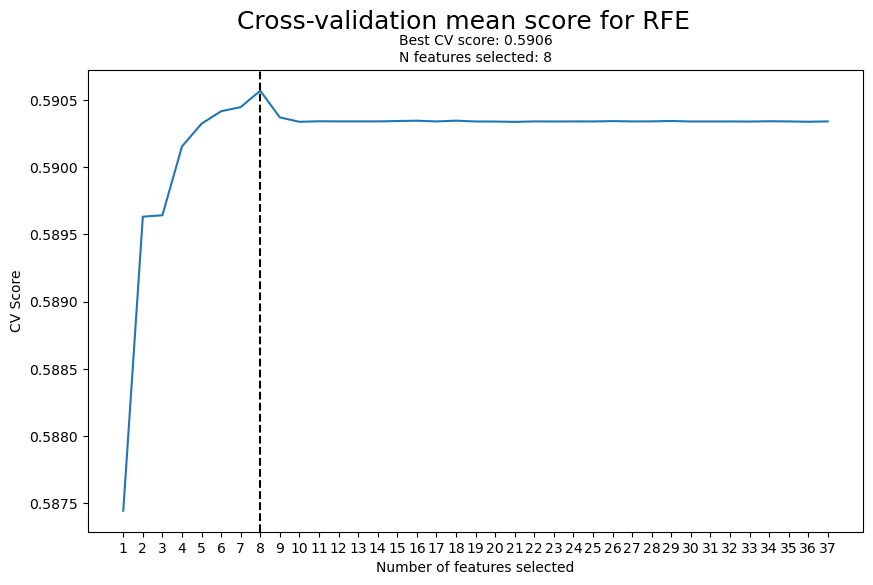

In [36]:
gkf = GroupKFold(n_splits=5)
model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)
rfe_df, selected_features, notselected_features, best_cv_score = rfecv_custom(model, gkf, 'roc_auc', X, y, name='lr')

We see the best model has 8 features and has a very small improvement in performance.

## Ensembling models with different sets of features to reduce overfitting <a class='anchor' id='ensembling'></a>
I've tried blending and stacking the predictions of several algorithms (including CatBoost, LGBM and XGBoost) and the single Logistic Regression algorithm outperforms those ensemblings. Because feature selection seems to have a large impact, we can ensemble different predictions from the Logistic Regression algorithm trained on different subsets of features.

The different subsets of features are:
- All the features before performing feature selection
- The set of features selected by Recursive Feature Elimination
- 3 other subsets selected by manual experimentation

In [37]:
features_all = X.columns.tolist()
features_rfecv = selected_features
features1 = ['loading', 'measurement_2', 'meas_float_mean', 'meas_float_std', 'm_3_missing', 'm_5_missing', 'ohe0_7', 'meas_float_max', 'ohe1_8', 'attribute_3', 'measurement_4', 'measurement_17', 'measurement_5', 'attribute_2', 'product_code', 'measurement_14', 'measurement_7']
features2 = ['loading', 'measurement_2', 'meas_float_mean', 'meas_float_std', 'm_3_missing', 'm_5_missing']
features3 = ['loading', 'measurement_2', 'meas_float_mean', 'meas_float_std']

features_dict = {'features_all': features_all, 'features_rfecv': features_rfecv, 'features1': features1, 'features2': features2, 'features3': features3}
ensembling_df = pd.DataFrame()


for name, features in features_dict.items():

    importances_list = []
    val_scores = []
    preds_test = np.zeros(test.shape[0])

    gkf = GroupKFold(n_splits=5)
    #prodsplit = ProductSplitter3v2()
    #skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, X['product_code'])):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=1)
        model.fit(X_train[features], y_train)

        pred_val = model.predict_proba(X_val[features])[:,1]
        val_score = roc_auc_score(y_val, pred_val)
        val_scores.append(val_score)

        pred_test = model.predict_proba(X_test[features])[:,1]
        preds_test += pred_test / 5

        importances_list.append(model.coef_.ravel())


        #print(f'FOLD {fold} AUC: {val_score}')
    print(f'MEAN CV AUC: {np.mean(val_scores)}')
    print('With features:')
    print(features)
    ensembling_df[name] = preds_test
    ensembling_df[name + '_score'] = np.mean(val_scores)


MEAN CV AUC: 0.5903398576933359
With features:
['product_code', 'loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17', 'm_3_missing', 'm_5_missing', 'meas_float_mean', 'meas_float_median', 'meas_float_std', 'meas_float_min', 'meas_float_max', 'meas_int_mean', 'meas_int_median', 'meas_int_std', 'meas_int_min', 'meas_int_max', 'ohe0_7', 'ohe1_6', 'ohe1_8']
MEAN CV AUC: 0.5905997407637091
With features:
['loading', 'attribute_3', 'measurement_2', 'measurement_4', 'm_3_missing', 'm_5_missing', 'meas_float_mean', 'ohe0_7']
MEAN CV AUC: 0.5903630248143377
With features:
['loading', 'measurement_2', 'meas_float_mean', 'meas_float_std', 'm_3_missing', 'm_5_missing', 'ohe0_7', 'meas_float_max', 'ohe1

In [38]:
print(ensembling_df.head(10))

   features_all  features_all_score  features_rfecv  features_rfecv_score  features1  features1_score  features2  features2_score  features3  features3_score
0      0.198770             0.59034        0.201519                0.5906   0.198730         0.590363   0.199151         0.590598   0.199237         0.590529
1      0.184685             0.59034        0.187270                0.5906   0.184672         0.590363   0.186552         0.590598   0.186639         0.590529
2      0.191536             0.59034        0.194624                0.5906   0.191552         0.590363   0.192656         0.590598   0.192716         0.590529
3      0.187064             0.59034        0.190452                0.5906   0.187069         0.590363   0.189117         0.590598   0.189139         0.590529
4      0.324553             0.59034        0.328058                0.5906   0.324536         0.590363   0.327763         0.590598   0.327878         0.590529
5      0.168454             0.59034        0.171211 

Let's compute the unweighted mean of the predictions and the mean weighted by the CV score.

In [39]:
preds_ensembling_mean = (ensembling_df['features_all'] + ensembling_df['features_rfecv'] + ensembling_df['features1'] + ensembling_df['features2'] + ensembling_df['features3']) / 5
preds_ensembling_mean_weightcv = (ensembling_df['features_all']*ensembling_df['features_all_score'] + ensembling_df['features_rfecv']*ensembling_df['features_rfecv_score'] + ensembling_df['features1']*ensembling_df['features1_score'] + ensembling_df['features2']*ensembling_df['features2_score'] + ensembling_df['features3']*ensembling_df['features3_score']) / (ensembling_df['features_all_score'] + ensembling_df['features_rfecv'] + ensembling_df['features1_score'] + ensembling_df['features2_score'] + ensembling_df['features3_score'])

## Hyperparameter tuning <a class='anchor' id='hyper'></a>
I've tried to increase performance by tuning the hyperparameters and it does not improve. I include the code here for reference.

In [40]:
'''
def objective(trial):

    params = {
        'random_state': trial.suggest_categorical('random_state', [1]),
        'C': trial.suggest_float('C', 0.001, 0.5),
        'penalty': trial.suggest_categorical('penalty', ['l1']),
        'solver': trial.suggest_categorical('solver', ['liblinear']),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_float('tol', 1e-6, 1e-2)
    }
    
    
    val_scores = []
    

    gkf = GroupKFold(n_splits=5)
    prodsplit = ProductSplitter3v2()
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, X['product_code'])):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = LogisticRegression(**params)
        model.fit(X_train, y_train)

        pred_val = model.predict_proba(X_val)[:,1]
        val_score = roc_auc_score(y_val, pred_val)
        val_scores.append(val_score)

        print(f'FOLD {fold} AUC: {val_score}')
    print(f'MEAN CV AUC: {np.mean(val_scores)}')
    
    return np.mean(val_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

lr_optuna_best = {'best_accuracy': study.best_value, 'best_params': study.best_params}

with open('Tables/lr_optuna_best.pickle', 'wb') as handle:
    pickle.dump(lr_optuna_best, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

"\ndef objective(trial):\n\n    params = {\n        'random_state': trial.suggest_categorical('random_state', [1]),\n        'C': trial.suggest_float('C', 0.001, 0.5),\n        'penalty': trial.suggest_categorical('penalty', ['l1']),\n        'solver': trial.suggest_categorical('solver', ['liblinear']),\n        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),\n        'max_iter': trial.suggest_int('max_iter', 100, 1000),\n        'tol': trial.suggest_float('tol', 1e-6, 1e-2)\n    }\n    \n    \n    val_scores = []\n    \n\n    gkf = GroupKFold(n_splits=5)\n    prodsplit = ProductSplitter3v2()\n    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)\n\n    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, X['product_code'])):\n        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]\n        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]\n\n        model = LogisticRegression(**params)\n        model.fit(X_train, y_train)\n\n    

#### Best trial

In [41]:
'''
with open('Tables/lr_optuna_best.pickle', 'rb') as handle:
    lr_optuna_best = pickle.load(handle)
    
print(lr_optuna_best)

optuna.visualization.plot_param_importances(study)
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)
#optuna.visualization.plot_slice(study, ['C'])
'''

"\nwith open('Tables/lr_optuna_best.pickle', 'rb') as handle:\n    lr_optuna_best = pickle.load(handle)\n    \nprint(lr_optuna_best)\n\noptuna.visualization.plot_param_importances(study)\noptuna.visualization.plot_optimization_history(study)\noptuna.visualization.plot_slice(study)\n#optuna.visualization.plot_slice(study, ['C'])\n"

# SUBMISSION <a class='anchor' id='submission'></a>
We submit the predictions of each of the individual models, the unweighted mean of the predictions and the weighted mean of the predictions. We see there is minimal differences between the scores. The model that achives a higher score is the one including all original features before performing manual or automatic feature selection. Ensembling models with different sets of features also does not improve performance. In this project, a single Logistic Regression algorithm with l1 regularization outperforms more complex strategies.

In [42]:
submission = pd.DataFrame({id: test[id], target: preds_ensembling_mean})
submission.to_csv('Submission files/submission_ensembling_mean.csv', index=False)
print(submission.head(10))
## Private Score: 0.59045
## Public Score: 0.58556


submission = pd.DataFrame({id: test[id], target: preds_ensembling_mean_weightcv})
submission.to_csv('Submission files/submission_ensembling_mean_weightcv.csv', index=False)
print(submission.head(10))
## Private Score: 0.59044
## Public Score: 0.58557

submission = pd.DataFrame({id: test[id], target: ensembling_df['features_all']})
submission.to_csv('Submission files/submission_features_all.csv', index=False)
print(submission.head(10))
## Private Score: 0.59051 (Best score)
## Public Score: 0.58535

submission = pd.DataFrame({id: test[id], target: ensembling_df['features_rfecv']})
submission.to_csv('Submission files/submission_features_rfecv.csv', index=False)
print(submission.head(10))
## Private Score: 0.59042
## Public Score: 0.58532

submission = pd.DataFrame({id: test[id], target: ensembling_df['features1']})
submission.to_csv('Submission files/submission_features1.csv', index=False)
print(submission.head(10))
## Private Score: 0.59051 (Best score)
## Public Score: 0.58534

submission = pd.DataFrame({id: test[id], target: ensembling_df['features2']})
submission.to_csv('Submission files/submission_features2.csv', index=False)
print(submission.head(10))
## Private Score: 0.59043
## Public Score: 0.58584

submission = pd.DataFrame({id: test[id], target: ensembling_df['features3']})
submission.to_csv('Submission files/submission_features3.csv', index=False)
print(submission.head(10))
## Private Score: 0.59
## Public Score: 0.58569


      id   failure
0  26570  0.199481
1  26571  0.185964
2  26572  0.192617
3  26573  0.188568
4  26574  0.326557
5  26575  0.169794
6  26576  0.167064
7  26577  0.231076
8  26578  0.149390
9  26579  0.173859
      id   failure
0  26570  0.229760
1  26571  0.215388
2  26572  0.222452
3  26573  0.218132
4  26574  0.358431
5  26575  0.197907
6  26576  0.194943
7  26577  0.262915
8  26578  0.175541
9  26579  0.202286
      id   failure
0  26570  0.198770
1  26571  0.184685
2  26572  0.191536
3  26573  0.187064
4  26574  0.324553
5  26575  0.168454
6  26576  0.165761
7  26577  0.229577
8  26578  0.148032
9  26579  0.172993
      id   failure
0  26570  0.201519
1  26571  0.187270
2  26572  0.194624
3  26573  0.190452
4  26574  0.328058
5  26575  0.171211
6  26576  0.168380
7  26577  0.233059
8  26578  0.150771
9  26579  0.175699
      id   failure
0  26570  0.198730
1  26571  0.184672
2  26572  0.191552
3  26573  0.187069
4  26574  0.324536
5  26575  0.168456
6  26576  0.165727
7  26577  0.